# Programming Foundations for Quantitative Finance

## Overview

This lab focuses on:

- Reproducibility (env capture, seeds, config)

- Data backbone with SQL/SQLite

- Research orchestration in Python

- Testing (unit tests) and logging

- Performance (vectorization, Numba, optional C++ kernel)

- Language integration (call C++ from Python)

- Optional R snapshot check with rpy2

- Git/Linux basics woven in as markdown “ops” cells

Tip: If your machine lacks a C++ compiler or rpy2, the notebook still runs (it falls back to pure-Python/Numba).


In [1]:

%pip install numpy pandas matplotlib scipy numba sqlalchemy sqlite-utils python-dotenv rpy2

import os, sys, math, json, time, hashlib, textwrap, warnings, platform
from dataclasses import dataclass
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sqlalchemy import create_engine
from sqlalchemy.engine import Engine
from scipy import stats
from numba import njit

warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (9, 5)
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

np.random.seed(42)  # reproducibility


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 44.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 58.8 MB/s  0:00:00m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11/11 [rpy2]2m 8/11 [numba]default-group]
Note: you may need to restart the kernel to use updated packages.


In [2]:
# reproducibility: capture environment and library versions for your experiment log
ENV_SNAPSHOT = {
    "python": sys.version,
    "platform": platform.platform(),
    "versions": {
        "numpy": np.__version__,
        "pandas": pd.__version__,
        "matplotlib": plt.matplotlib.__version__,
        "scipy": stats.__version__ if hasattr(stats, "__version__") else "n/a",
        "numba": njit.__module__.split('.')[0]  # quick presence check
    },
}
ENV_SNAPSHOT


{'python': '3.11.0 (v3.11.0:deaf509e8f, Oct 24 2022, 14:43:23) [Clang 13.0.0 (clang-1300.0.29.30)]',
 'platform': 'macOS-26.0-arm64-arm-64bit',
 'versions': {'numpy': '1.24.3',
  'pandas': '2.0.3',
  'matplotlib': '3.6.3',
  'scipy': 'n/a',
  'numba': 'numba'}}

In [12]:
# SQLite research db (shcema + sample data)
# in prod we would ETL from a datalake (ie snowflake)

DB_PATH = Path("research_topic14.sqlite").absolute()
engine: Engine = create_engine(f"sqlite:///{DB_PATH}")

# schema: wide table of daily log returns by symbol
with engine.begin() as con:
    con.exec_driver_sql("""
        CREATE TABLE IF NOT EXISTS returns (
            date TEXT NOT NULL,
            symbol TEXT NOT NULL,
            logret REAL NOT NULL,
            PRIMARY KEY(date, symbol)
        );
    """)


In [13]:
# generate synthetic daily log-returns for AAPL/MSFT/SPY with a shared covariance
dates = pd.bdate_range("2019-01-01", "2024-12-31")
symbols = ["AAPL", "MSFT", "SPY"]
n = len(symbols)

# target mean and covariance (annualized-ish; we’ll convert to daily scale)
mu_ann = np.array([0.14, 0.12, 0.07])
vol_ann = np.array([0.30, 0.28, 0.18])
corr = np.array([[1.00, 0.75, 0.65],
                 [0.75, 1.00, 0.60],
                 [0.65, 0.60, 1.00]])
Sigma_ann = np.outer(vol_ann, vol_ann) * corr

# convert to daily (approx 252 trading days)
mu_day = mu_ann / 252.0
Sigma_day = Sigma_ann / 252.0

L = np.linalg.cholesky(Sigma_day)
Z = np.random.randn(len(dates), n)
R = (Z @ L.T) + mu_day  # daily log-returns matrix

df = pd.DataFrame(R, index=dates, columns=symbols)
df = df.stack().rename("logret").reset_index()
df.columns = ["date", "symbol", "logret"]
df["date"] = df["date"].dt.strftime("%Y-%m-%d")

with engine.begin() as con:
    # idempotent upsert for simplicity: clear and reinsert
    con.exec_driver_sql("DELETE FROM returns;")
    df.to_sql("returns", con=con, if_exists="append", index=False)
len(df), df.head()


(4698,
          date symbol    logret
 0  2019-01-01   AAPL  0.009943
 1  2019-01-01   MSFT  0.005434
 2  2019-01-01    SPY  0.009112
 3  2019-01-02   AAPL  0.029338
 4  2019-01-02   MSFT  0.017892)

In [14]:
# python orchestration
# query SQL > compute mean, covariance > portfolio metrics

def load_returns(engine: Engine, symbols=None, start=None, end=None) -> pd.DataFrame:
    query = "SELECT date, symbol, logret FROM returns"
    clauses = []
    if start: clauses.append(f"date >= '{start}'")
    if end:   clauses.append(f"date <= '{end}'")
    if symbols:
        syms = ",".join([f"'{s}'" for s in symbols])
        clauses.append(f"symbol IN ({syms})")
    if clauses:
        query += " WHERE " + " AND ".join(clauses)
    query += " ORDER BY date, symbol"
    df = pd.read_sql_query(query, engine, parse_dates=["date"])
    return df

raw = load_returns(engine, symbols=["AAPL", "MSFT", "SPY"], start="2020-01-01")
pivot = raw.pivot(index="date", columns="symbol", values="logret").dropna()
mu = pivot.mean()             # daily mean vector
Sigma = pivot.cov()           # daily covariance matrix
mu, Sigma.head()


(symbol
 AAPL    0.000179
 MSFT    0.000239
 SPY     0.000535
 dtype: float64,
 symbol      AAPL      MSFT       SPY
 symbol                              
 AAPL    0.000362  0.000243  0.000136
 MSFT    0.000243  0.000300  0.000114
 SPY     0.000136  0.000114  0.000122)

In [15]:
def portfolio_stats(w: np.ndarray, mu: pd.Series, Sigma: pd.DataFrame):
    er = float(w @ mu.values)
    var = float(w @ Sigma.values @ w)
    vol = math.sqrt(var)
    return er, vol, var

w_eq = np.repeat(1.0/len(mu), len(mu))
er_d, vol_d, var_d = portfolio_stats(w_eq, mu, Sigma)

pd.Series({
    "mu_daily": er_d,
    "vol_daily": vol_d,
    "mu_annual": er_d*252,
    "vol_annual": vol_d*np.sqrt(252)
}).round(6)


mu_daily      0.000318
vol_daily     0.014018
mu_annual     0.080038
vol_annual    0.222527
dtype: float64

In [16]:
# testing, unit tests to keep numbers honest
# using pythons unittest

import unittest
class TestPortfolioMath(unittest.TestCase):
    def test_dimensions(self):
        self.assertEqual(Sigma.shape[0], Sigma.shape[1])
        self.assertEqual(Sigma.shape[0], mu.shape[0])
    def test_psd(self):
        # covariance should be PSD (allow small numeric slop)
        e = np.linalg.eigvalsh(Sigma.values)
        self.assertTrue(np.all(e > -1e-12))
    def test_weights(self):
        self.assertAlmostEqual(w_eq.sum(), 1.0, places=12)
        self.assertTrue(np.all(w_eq >= 0))
    def test_stats_sign(self):
        er, vol, var = portfolio_stats(w_eq, mu, Sigma)
        self.assertTrue(vol >= 0 and var >= 0)

suite = unittest.TestLoader().loadTestsFromTestCase(TestPortfolioMath)
unittest.TextTestRunner(verbosity=2).run(suite);


test_dimensions (__main__.TestPortfolioMath.test_dimensions) ... ok
test_psd (__main__.TestPortfolioMath.test_psd) ... ok
test_stats_sign (__main__.TestPortfolioMath.test_stats_sign) ... ok
test_weights (__main__.TestPortfolioMath.test_weights) ... ok

----------------------------------------------------------------------
Ran 4 tests in 0.012s

OK


In [17]:
# logging and lightweight config

import logging, yaml

# config that would usually live in a YAML file committed to Git
CONFIG_YAML = """
universe: ["AAPL", "MSFT", "SPY"]
date_start: "2020-01-01"
report:
  paths:
    out_dir: "topic14_outputs"
"""

cfg = yaml.safe_load(CONFIG_YAML)
OUT_DIR = Path(cfg["report"]["paths"]["out_dir"]); OUT_DIR.mkdir(exist_ok=True)

# logging to file for audit trail
log_path = OUT_DIR / "run.log"
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s",
    handlers=[logging.FileHandler(log_path), logging.StreamHandler(sys.stdout)]
)
logging.info("Starting Topic 1.4 run")
logging.info("Env snapshot: %s", json.dumps(ENV_SNAPSHOT))


2025-10-06 12:03:52,691 | INFO | Starting Topic 1.4 run
2025-10-06 12:03:52,692 | INFO | Env snapshot: {"python": "3.11.0 (v3.11.0:deaf509e8f, Oct 24 2022, 14:43:23) [Clang 13.0.0 (clang-1300.0.29.30)]", "platform": "macOS-26.0-arm64-arm-64bit", "versions": {"numpy": "1.24.3", "pandas": "2.0.3", "matplotlib": "3.6.3", "scipy": "n/a", "numba": "numba"}}


In [18]:
# performance, pytohn loop vs vectorized vs numba vs c++

series = pivot["AAPL"].values.astype(np.float64)
window = 63  # 3 months

def rolling_var_loop(x, w):
    out = np.full_like(x, np.nan)
    for i in range(w-1, len(x)):
        seg = x[i-w+1:i+1]
        out[i] = np.var(seg, ddof=1)
    return out

def rolling_var_vec(x, w):
    # Vectorized via cumulative sums (note: ddof=1 correction)
    x = x.astype(np.float64)
    csum = np.cumsum(np.insert(x, 0, 0.0))
    csum2 = np.cumsum(np.insert(x*x, 0, 0.0))
    n = len(x)
    out = np.full(n, np.nan)
    for i in range(w-1, n):
        s1 = csum[i+1] - csum[i+1-w]
        s2 = csum2[i+1] - csum2[i+1-w]
        mean = s1 / w
        var = (s2 - w*mean*mean) / (w - 1)
        out[i] = var
    return out

@njit(fastmath=True)
def rolling_var_numba(x, w):
    n = x.shape[0]
    out = np.empty(n); out[:] = np.nan
    for i in range(w-1, n):
        s = 0.0; s2 = 0.0
        for j in range(i-w+1, i+1):
            v = x[j]; s += v; s2 += v*v
        mean = s / w
        out[i] = (s2 - w*mean*mean) / (w - 1)
    return out


In [19]:
def timeit_ms(fn, *args, repeat=3, **kwargs):
    best = 1e9
    for _ in range(repeat):
        t0 = time.time()
        _ = fn(*args, **kwargs)
        best = min(best, (time.time() - t0)*1000)
    return best

t_loop = timeit_ms(rolling_var_loop, series, window)
t_vec  = timeit_ms(rolling_var_vec, series, window)
_ = rolling_var_numba(series, window)  # compile warm-up
t_numba = timeit_ms(rolling_var_numba, series, window)

pd.Series({"python_loop_ms": t_loop, "vectorized_ms": t_vec, "numba_ms": t_numba}).round(3)


python_loop_ms    13.531
vectorized_ms      1.122
numba_ms           0.057
dtype: float64

In [20]:
# portfolio variance kernel, python/numpy vs c++

# python base
def port_var_numpy(w: np.ndarray, Sigma: np.ndarray) -> float:
    return float(w @ Sigma @ w)

w = w_eq.copy()
Sigma_np = Sigma.values
port_var_numpy(w, Sigma_np)


0.00019650029662048802

In [24]:
# c++ shared libarary (loaded via ctypes in python)

from pathlib import Path, PurePath
from ctypes import CDLL, c_double, POINTER, c_int
import subprocess, sys

CPP_CODE = r"""
#include <vector>
extern "C" {
    // Compute w^T Sigma w where Sigma is row-major n x n, w length n
    double port_var(const double* w, const double* Sigma, int n) {
        // temp = Sigma * w
        std::vector<double> temp(n, 0.0);
        for (int i = 0; i < n; ++i) {
            const double* row = Sigma + i*n;
            double acc = 0.0;
            for (int j = 0; j < n; ++j) acc += row[j] * w[j];
            temp[i] = acc;
        }
        // return w^T temp
        double out = 0.0;
        for (int i = 0; i < n; ++i) out += w[i] * temp[i];
        return out;
    }
}
"""

CPP_DIR = Path("cpp_kernel"); CPP_DIR.mkdir(exist_ok=True)
CPP_PATH = CPP_DIR / "portvar.cpp"
SO_PATH  = CPP_DIR / ("portvar.so" if sys.platform != "win32" else "portvar.dll")

CPP_PATH.write_text(CPP_CODE)

compile_cmd = ["g++", "-O3", "-std=c++17", "-shared", "-fPIC", str(CPP_PATH), "-o", str(SO_PATH)]
try:
    subprocess.check_call(compile_cmd)
    lib = CDLL(str(SO_PATH))
    lib.port_var.argtypes = [POINTER(c_double), POINTER(c_double), c_int]
    lib.port_var.restype = c_double

    def port_var_cpp(w: np.ndarray, Sigma: np.ndarray) -> float:
        w_c = w.astype(np.float64, copy=False)
        S_c = Sigma.astype(np.float64, copy=False)
        return lib.port_var(w_c.ctypes.data_as(POINTER(c_double)),
                            S_c.ctypes.data_as(POINTER(c_double)),
                            c_int(w_c.shape[0]))
    pv_py  = port_var_numpy(w, Sigma_np)
    pv_cpp = port_var_cpp(w, Sigma_np)
    pd.Series({"python/BLAS": pv_py, "C++/ctypes": pv_cpp})
except Exception as e:
    print("C++ compile/load failed:", e)
    port_var_cpp = None


In [28]:
# benchmark (if C++ loaded successfully)
if port_var_cpp is not None:
    t_py  = timeit_ms(port_var_numpy, w, Sigma_np)
    t_cpp = timeit_ms(port_var_cpp, w, Sigma_np)
    pd.Series({"portvar_numpy_ms": t_py, "portvar_cpp_ms": t_cpp}).round(4)
else:
    print("Skipping C++ benchmark (compiler unavailable).")


In [25]:
# numeric equality and unit test

import unittest
class TestPortVarKernel(unittest.TestCase):
    def test_numpy_positive(self):
        self.assertGreaterEqual(port_var_numpy(w, Sigma_np), 0.0)
    def test_cpp_matches_numpy(self):
        if port_var_cpp is None:
            self.skipTest("C++ kernel not available")
        pv_py = port_var_numpy(w, Sigma_np)
        pv_c  = port_var_cpp(w, Sigma_np)
        self.assertAlmostEqual(pv_py, pv_c, places=12)

suite = unittest.TestLoader().loadTestsFromTestCase(TestPortVarKernel)
unittest.TextTestRunner(verbosity=2).run(suite);


test_cpp_matches_numpy (__main__.TestPortVarKernel.test_cpp_matches_numpy) ... ok
test_numpy_positive (__main__.TestPortVarKernel.test_numpy_positive) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.004s

OK


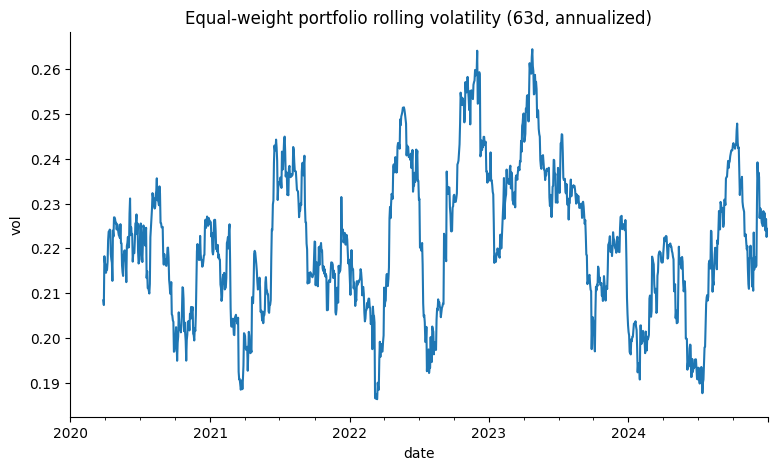

artefacts.json    ac90f5756a04a1ca3443ec0ddc161467a6066fa9be47ac...
run.log           d3acc25bc10d916c830faff9be4a258b2a4ba8bfd22a97...
dtype: object

In [26]:
# outputs and reporting (plots + hashes for audit)

# Plot rolling vol of equal-weight portfolio
pnl = pivot @ w_eq
roll_vol = pnl.rolling(63).std() * np.sqrt(252)

plt.figure()
roll_vol.plot()
plt.title("Equal-weight portfolio rolling volatility (63d, annualized)")
plt.ylabel("vol"); plt.xlabel("date")
plt.show()

# Persist artifacts with content hashes
artefacts = {
    "mu_daily": mu.to_dict(),
    "Sigma_daily": Sigma.round(10).to_dict(),
    "w_eq": {s: float(v) for s, v in zip(mu.index, w_eq)},
    "env": ENV_SNAPSHOT
}
out_json = OUT_DIR / "artefacts.json"
with open(out_json, "w") as f:
    json.dump(artefacts, f, indent=2, sort_keys=True)

def file_sha256(path: Path) -> str:
    h = hashlib.sha256()
    with open(path, "rb") as f:
        h.update(f.read())
    return h.hexdigest()

pd.Series({
    "artefacts.json": file_sha256(out_json),
    "run.log": file_sha256(OUT_DIR / "run.log")
})


In [27]:
# R interop: check of sample means via rpy2

try:
    import rpy2.robjects as ro
    from rpy2.robjects import pandas2ri
    pandas2ri.activate()
    ro.r("R.version.string")
    # Ship pivot to R and compute column means
    r_df = pandas2ri.py2rpy(pivot)
    ro.globalenv["X"] = r_df
    r_means = ro.r("colMeans(X, na.rm=TRUE)")
    pd.Series(np.array(r_means), index=pivot.columns, name="R_colMeans")
except Exception as e:
    print("R/rpy2 not available:", e)


2025-10-06 12:07:55,629 | INFO | cffi mode is CFFI_MODE.ANY
2025-10-06 12:07:55,816 | INFO | R home found: /Library/Frameworks/R.framework/Resources
2025-10-06 12:07:56,749 | INFO | R library path: 
2025-10-06 12:07:56,750 | INFO | LD_LIBRARY_PATH: 
2025-10-06 12:07:56,789 | WARNING | Error importing in API mode: ImportError("dlopen(/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/_rinterface_cffi_api.abi3.so, 0x0002): Library not loaded: /Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib\n  Referenced from: <20FB70DB-7E84-3375-A520-E0350E06C060> /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/_rinterface_cffi_api.abi3.so\n  Reason: tried: '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file), '/Library/Frameworks/R.frame

In [ ]:
"""
1. Reproducibility vs Speed

When working in quantititive finance your systems, models and
automations have to be reproducible, and in many cases fast.
Ensuring you have a solid version control, dockeriztion system, 
logging and clean code standards are a few of the steps that would
help ensure you are creating reproducible products.

The tradeoff between speed and reproducibility depends on what
your desired outcomes are. For a market maker that profits off of
the spread and nanosecond - milisecond discrepencies, speed is
likley the priority, and reproducibility could be sacrificed. On
the other hand if you are a Reasearch or Prop Shop, you might be
working on building and distributing a large variety of strategies
and focus on reproducibility of your systems/automations so that
you can quickly and repeatedly build, test, and evaluate strategies.

2. Right Tool for The Job

For cleaning a messy corporate actions feed (data) I would use SQL
becuase it is a query language (used to fetch, move, and place data)
which is perfect for organizing a database. For running an 10,000
path Monte Carlo pricer under time pressure I would use C++ because
it is great for high volume tasks that also need speed optimization
which is hinted at with the time pressure constraint. Lastly for
performing hypothesis tests on factor ICs I would use R programming
language becuase it is great for statistical analysis of data.

3. Testing what Matters

Given a min-var backtest that suddenly improved by 20% after small
refactors. I would check for leakage/bugs by running a timestamp
shift (look ahead bias) test. This would be performed by lagging
every inpput by +1 bar. If the performance collapses to the old level
or worse, the previous run was using future info. Secondly, I would
run the backtest with costs on and costs off to make sure that the
PNL with costs off >= PNL with costs on. A sudden drop in costs or
turnover constraints often explains a "free" +20%

To catch this next time we can make sure no feature or estimator
may include data from the decision bar. This means at decision time
t features/stats must be built from data strictly before t. This
assert would rule out look ahead bias. Also have an assert that
woud fail if the after costs PNL >= before costs PNL. This is
checking for costs inequality.

"""